# Data Science Pipeline
### Planning >> Data Collection >> Data Cleanup >> Visualization >> Deliver Insight

Planning 
- Creating a GitHub site for easy file management and collaboration
- Brainstorm on topics and identify data sources

Data Collection
- Scraping data from Zillow website
- Data transformation

Data Cleanup
- Data review
- Identifying and removing outliers

Visualization
- Explore data

Deliver Insight
- Document all processes and code in Jupyter notebook.

# Data Collection

### Zillow Scraping Full Example

### Import scraper and utility modules
- Create a "scraper" object that will perform the scraping of zillow website data
- Create bounding boxes of latitudes and longitudes for two cities Vancouver, BC in Canada and Los Angeles, CA in USA
- The data from these two cities will be combined for the final analysis

In [7]:
from src.webscraper.zillow_scraper_v3 import ZillowScraper
from src.webscraper.utils.scraper_utils import divide_rectangle, json_savefile, visualize_boxes, point_to_line_dist



In [ ]:
scraper = ZillowScraper()

LA_box = {'west_bound': -118.7,
          'east_bound': -117.6,
          'south_bound': 33.5,
          'north_bound': 34.5}

Vancouver_box = {'west_bound': -123.35,
                 'east_bound': -122.7,
                 'south_bound': 49.0,
                 'north_bound': 49.4}


### Subdivide the query into smaller partitions
- Since Zillow's website limits the number of listings that can be returned from a scrape to a max of 500, there is a need to subdivide the scrape to capture as much data as possible
- The bounding box for each city is subdivided into 0.01 Square Kilometer sub-boxes, and the scraping will be performed on those iteratively
- This may still miss some listings in very high density areas (some sub-boxes still have more than 500 listings) but at least it should provide a decent representation of house listing data in each city for the analysis
- There are also boxes that are not likely to contain any listings (ie in the ocean), which doesn't pose problems since they'll just return zero listings and be passed over

In [2]:
Vancouver_sub_boxes = divide_rectangle(Vancouver_box, limit=0.01)
LA_sub_boxes = divide_rectangle(LA_box, limit=0.01)

In [3]:
# Visualize the data comprising one of the sub-boxes in Vancouver
sub_box = Vancouver_sub_boxes[0]
sub_box

{'west_bound': -123.35,
 'east_bound': -123.22,
 'south_bound': 49.0,
 'north_bound': 49.1}

In [4]:
# Visualizing all of these sub-boxes on a map for Vancouver, BC
vancouver_map = visualize_boxes(Vancouver_sub_boxes)
vancouver_map

In [5]:
# Visualizing all of these sub-boxes on a map for Los Angeles, CA
LA_map = visualize_boxes(LA_sub_boxes)
LA_map

### Once the sub-boxes are established, the scraping is performed via looping through all sub-boxes
- Parallizing this scrape will cause a ban from Zillow's anti-scraping mechanism, therefore we are limited to using single thread loop to go through all sub-boxes in each city
- The scrape takes ~2.5 hours to complete, and returned 4322 listings in Vancouver, and 11153 listings in Los Angeles

In [ ]:
vancouver_listings = []
for sub_box in Vancouver_sub_boxes:
    sub_box_data=scraper.scrape_listings(
            west_bound=sub_box["west_bound"],
            east_bound=sub_box["east_bound"],
            south_bound=sub_box["south_bound"],
            north_bound=sub_box["north_bound"],
            search_term='Vancouver, BC',
        )
    
    vancouver_listings += sub_box_data
    
print(f"Scraped a total of {len(vancouver_listings)} in Vancouver, BC, Canada")

In [ ]:
LA_listings = []
for sub_box in LA_sub_boxes:
    sub_box_data=scraper.scrape_listings(
            west_bound=sub_box["west_bound"],
            east_bound=sub_box["east_bound"],
            south_bound=sub_box["south_bound"],
            north_bound=sub_box["north_bound"],
            search_term='Los Angeles, CA',
        )
    
    LA_listings += sub_box_data
    
print(f"Scraped a total of {len(LA_listings)} in Los Angeles, CA, United States")

In [8]:
# the raw outputs of the scrape is stored for future usage
json_savefile(vancouver_listings, "vancouver_listings_scraped.json")
json_savefile(LA_listings, "LA_listings_scraped.json")


json output file saved to vancouver_listings_scraped.json
json output file saved to LA_listings_scraped.json


### Obtaining the distance to waterfront
- Both cities are coastal cities, therefore the distance to waterfront is a common feature we can obtain for both sets of listings scrapd
- This is done by first creating a polyline manually that roughly traces the coast line to the pacific ocean
- Then for each listing we take its latitude and longitude obtained from the Zillow scrape, and estimate this property's distance to the nearest point along the polyine of the city's coastline
- From the utils module the point_to_line_dist() function will return a distance in kilometers

In [2]:
# starting from reading the scraped json file without rerunning the scraper

import json
import pandas as pd
import numpy as np

with open('vancouver_listings_scraped.json') as f:
    vancouver_listings = json.load(f)
    
with open('LA_listings_scraped.json') as f:
    LA_listings = json.load(f)

In [3]:
import folium

# obtained by manually estimating points along the coastline for Vancouver and Los Angeles to the Pacific Ocean

LA_coastline = [
    (34.0032, -118.8062),
    (34.0078, -118.5095),
    (33.8005, -118.3914),
    (33.7617, -118.4079),
    (33.6978, -118.2843),
    (33.7457, -118.1140),
    (33.5904, -117.9135),
    (33.2077, -117.3917)
]

Vancouver_coastline = [
    (49.4179, -123.2336),
    (49.3322, -123.2652),
    (49.3223, -123.1416),
    (49.2758, -123.1485),
    (49.2758, -123.2639),
    (49.2194, -123.2185),
    (49.0820, -123.1842),
    (49.0327, -123.1073),
    (48.9678, -123.0826),
    (48.9714, -123.0125),
    (49.0435, -123.0414),
    (49.0866, -122.8725),
    (49.0273, -122.8807),
    (49.0021, -122.7755)
]



In [4]:

# Create a folium map centered on Vancouver
vancouver_coastline_map = folium.Map(location=[49.2497, -123.1193], zoom_start=10)

# Add the Vancouver coastline to the map as a polyline
folium.PolyLine(Vancouver_coastline, color="red", weight=2.5, opacity=1).add_to(vancouver_coastline_map)
vancouver_coastline_map

In [5]:
# Create a folium map centered on Los Angeles
LA_coastline_map = folium.Map(location=[33.7617, -118.4079], zoom_start=9)

# Add the Vancouver coastline to the map as a polyline
folium.PolyLine(LA_coastline, color="red", weight=2.5, opacity=1).add_to(LA_coastline_map)
LA_coastline_map

In [8]:
# calculate the distance to the coastline for each property in Vancouver, BC

for listing in vancouver_listings:
    lat = listing['latLong']['latitude']
    long = listing['latLong']['longitude']
    listing['distance_to_waterfront'] = point_to_line_dist((lat, long), Vancouver_coastline)
    listing['query_city'] = 'Vancouver'

# calculate the distance to the coastline for each property in Los Angeles, CA
for listing in LA_listings:
    lat = listing['latLong']['latitude']
    long = listing['latLong']['longitude']
    listing['distance_to_waterfront'] = point_to_line_dist((lat, long), LA_coastline)
    listing['query_city'] = 'Los Angeles'
    

### Finally the two sets of listings are combined into a single list and written as the final scraped dataset for further processing in pandas

In [10]:
combined_listings = vancouver_listings+LA_listings
# Show the total number of listings combined from the two cities
print(len(combined_listings))
# Show the data in one of the listings as an example
combined_listings[1]

15475


{'zpid': '314544781',
 'price': 'C$499,999',
 'priceLabel': 'C$500K',
 'beds': 3,
 'baths': 2.0,
 'area': 1689,
 'latLong': {'latitude': 49.086514, 'longitude': -123.10376},
 'statusType': 'FOR_SALE',
 'statusText': 'House for sale',
 'isFavorite': False,
 'isUserClaimingOwner': False,
 'isUserConfirmedClaim': False,
 'imgSrc': 'https://photos.zillowstatic.com/fp/20ba9596fccc71832cf85fde546fdf95-p_e.jpg',
 'hasImage': True,
 'visited': False,
 'listingType': '',
 'variableData': None,
 'hdpData': {'homeInfo': {'zpid': 314544781,
   'zipcode': 'V4K1R9',
   'city': 'Delta',
   'state': 'BC',
   'latitude': 49.086514,
   'longitude': -123.10376,
   'price': 499999.0,
   'bathrooms': 2.0,
   'bedrooms': 3.0,
   'livingArea': 1689.0,
   'homeType': 'SINGLE_FAMILY',
   'homeStatus': 'FOR_SALE',
   'daysOnZillow': -1,
   'isFeatured': False,
   'shouldHighlight': False,
   'listing_sub_type': {'is_FSBA': True},
   'isUnmappable': False,
   'isPreforeclosureAuction': False,
   'homeStatusForHD

In [11]:
# save this output to a file for later use
json_savefile(combined_listings, 'zillow_all_listings_scraped.json')

json output file saved to zillow_all_listings_scraped.json


# Data Cleanup

### Objectives:
- Read JSON file
- Missing value imputation
- Removing illegal characters in numeric columns
- Extracting key information from free from fields
- Removing outliers

In [4]:
from src.data_manipulation.data_cleanup import clean_json_file
from src.data_manipulation.data_cleanup import clean_data
import pandas as pd
import numpy as np

inFile = 'zillow_all_listings_scraped.json'
df = clean_json_file(inFile)

In [5]:
## Data sample
print(df.head(2))

       price  bedrooms  bathrooms    sqft   city state   latitude  longitude  \
1   499999.0       3.0        2.0  1689.0  Delta    BC  49.086514 -123.10376   
2  1679000.0       4.0        4.0  2679.0  Delta    BC  49.089947 -123.09065   

        homeType homeStatus  ...  \
1  SINGLE_FAMILY   FOR_SALE  ...   
2  SINGLE_FAMILY   FOR_SALE  ...   

                                            features ind_HasPool  \
1  Adult Oriented, Marina Nearby, Recreation Near...       False   
2                                                 NA       False   

   ind_GolfCourseNearby ind_ShoppingNearby  ind_Clubhouse  \
1                 False               True          False   
2                 False              False          False   

   ind_RecreationNearby  ind_ParkNearby  ind_IsCornerLot  ind_IsCuldesac  \
1                  True           False            False           False   
2                 False           False            False           False   

   price/sqft  
1  296.032564  


In [6]:
print(df.describe())

              price     bedrooms     bathrooms          sqft      latitude  \
count  1.317600e+04  13176.00000  13176.000000  13176.000000  13176.000000   
mean   2.360501e+06      4.19027      3.578780   2689.166211     38.254771   
std    4.553969e+06      3.87924      3.619893   2669.014600      6.835788   
min    1.000000e+02      0.00000      0.000000      0.000000     33.500732   
25%    7.777500e+05      3.00000      2.000000   1342.000000     33.936267   
50%    1.259000e+06      4.00000      3.000000   1980.000000     34.095067   
75%    2.341250e+06      5.00000      4.000000   3135.250000     49.056387   
max    1.550000e+08    132.00000    112.000000  56500.000000     49.398810   

          longitude  distance_to_waterfront  ind_HasGarage    price/sqft  
count  13176.000000            13176.000000    13176.00000  1.317600e+04  
mean    -119.514975               19.589444        1.81527           inf  
std        2.174354               15.492673       17.27672           NaN

### Data Dictionary of Variables

| Attribute | Definition | Data Type |
| --- | --- | --- |
| price | List price | float64
| bedrooms | Number of bedrooms | float64
| bathrooms | Number of bathrooms | float64
| sqft | Square footage | float64
| city | City | object
| state | State | object
| latitude | Latitude                 | float64
| longitude | Longitude               | float64
| homeType | Indicates if the home is a single-family, condo or townouse | object
| homeStatus | For Sale vs For Rent | object
| distance_to_waterfront | Distance to coastline | float64
| additional_info | Additional listing information | object
| ind_HasGarage | Number of garage stall | float64
| features | Additional features | object
| ind_HasPool | Property has a pool | bool
| ind_GolfCourseNearby | Property is close to a golf course | bool
| ind_ShoppingNearby | Property is nearby stores | bool
| ind_Clubhouse | Property has a clubhouse | bool
| ind_RecreationNearby | Property is close to recreation centers | bool
| ind_ParkNearby | Property is a close to a park | bool
| ind_IsCornerLot | Property is a corner lot | bool
| ind_IsCuldesac | Property in a cul-de-sac | bool
| price/sqft | Price per square foot | float64

### Identifying and removing outliers

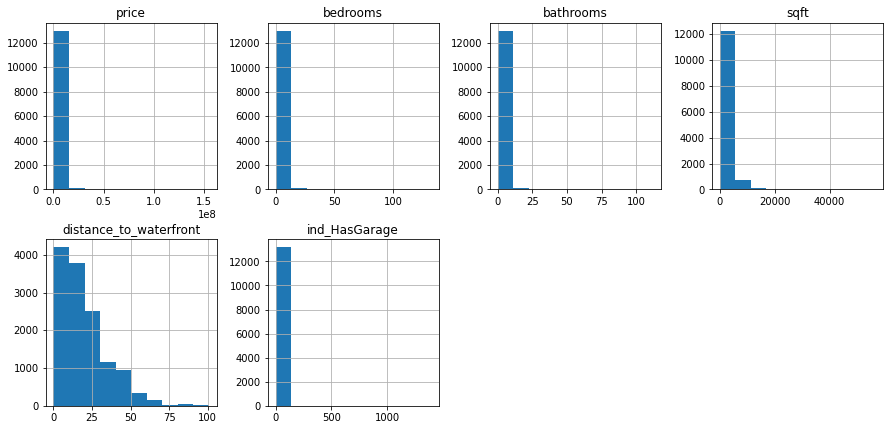

In [7]:
ax_list = df[['price','bedrooms','bathrooms','sqft','distance_to_waterfront','ind_HasGarage']].hist(bins=10, layout=(4,4), figsize=(15,15))

### Removing outliers

In [8]:
from src.data_manipulation.data_cleanup import removeOutliers
 
df_clean = removeOutliers(df, 'price')
df_clean = removeOutliers(df_clean, 'bedrooms')
df_clean = removeOutliers(df_clean, 'bathrooms')
df_clean = removeOutliers(df_clean, 'sqft')
df_clean = removeOutliers(df_clean, 'ind_HasGarage')


IQR value for column price is: 1563500.0
IQR value for column bedrooms is: 1.0
IQR value for column bathrooms is: 1.0
IQR value for column sqft is: 972.0
IQR value for column ind_HasGarage is: 2.0


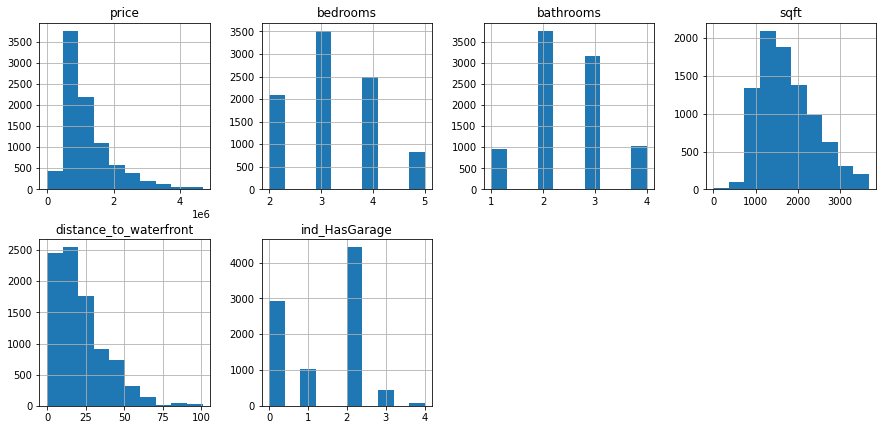

In [9]:
ax_list = df_clean[['price','bedrooms','bathrooms','sqft','distance_to_waterfront','ind_HasGarage']].hist(bins=10, layout=(4,4), figsize=(15,15))


X:\Madz Documents\Python\VirtualEnv\venv_C4447\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


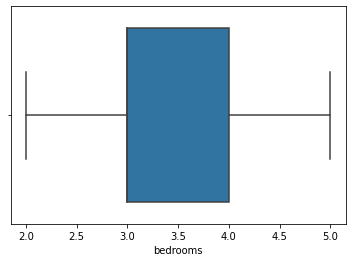

In [10]:
## Checking for outliers
import seaborn as sns
import matplotlib.pyplot as plt
sns.boxplot(df_clean['bedrooms'])
#plt.title("Bedrooms")
plt.show()

X:\Madz Documents\Python\VirtualEnv\venv_C4447\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


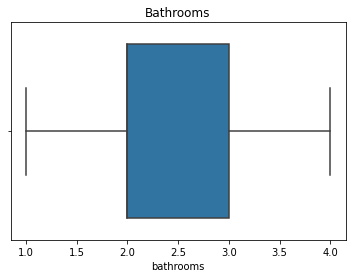

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.boxplot(df_clean['bathrooms'])
plt.title("Bathrooms")
plt.show()

# 4 - Visualize Data

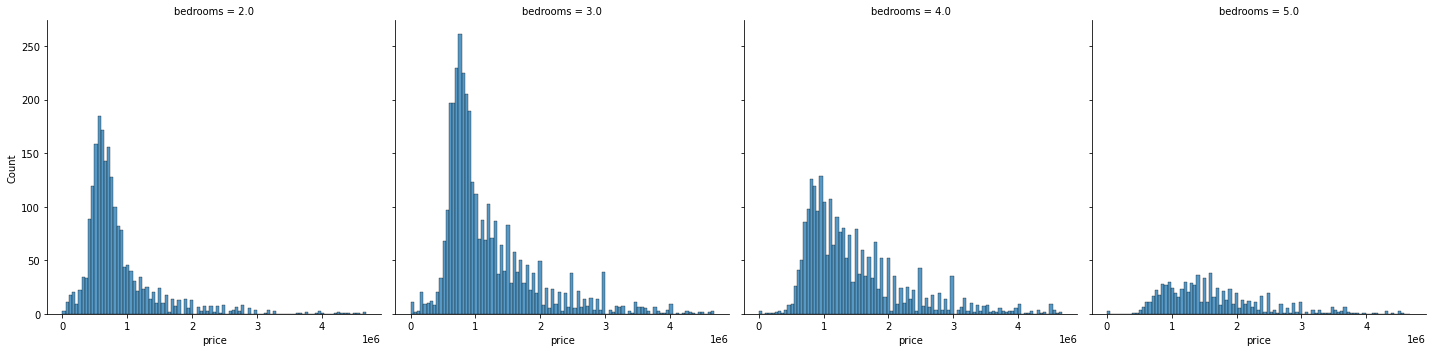

In [12]:
sns.displot(data=df_clean, x='price', bins='sqrt', kind='hist', col='bedrooms')
plt.show()

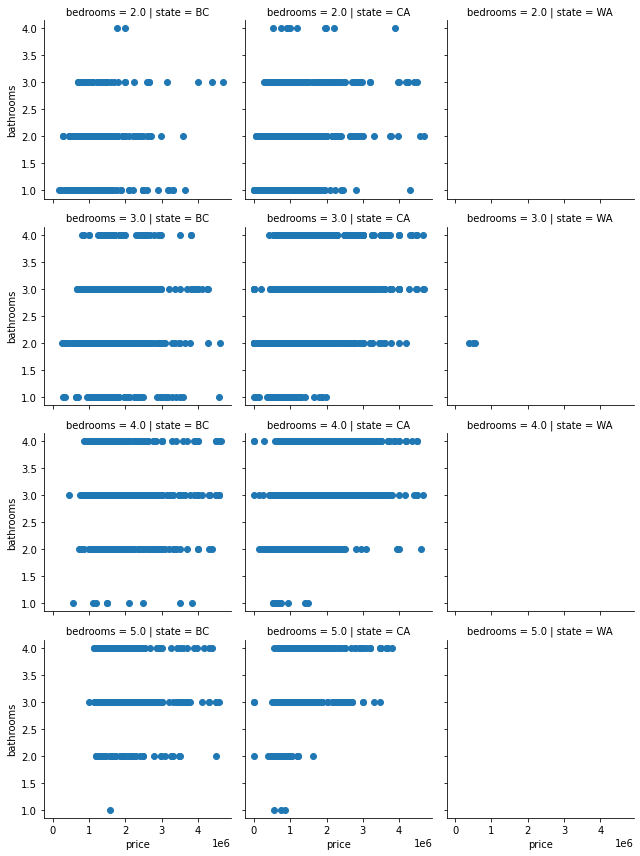

In [13]:
df_clean['bedrooms'] = df_clean['bedrooms'].astype('category')
df_clean['bathrooms'] = df_clean['bathrooms'].astype('category')
df_clean['city'] = df_clean['city'].astype('category')
df_clean['state'] = df_clean['state'].astype('category')



#sns.set_style('darkgrid')
p1 = sns.FacetGrid(df_clean,col='state',row='bedrooms')
p1 = p1.map(plt.scatter,'price','bathrooms') 
plt.show(p1)
